<a href="https://colab.research.google.com/github/FraPochetti/KagglePlaygrounds/blob/master/KeypointsDet_BIWI_IceVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keypoints detection with IceVision

The purpose of this notebook is to show how to implement the latest addition to the IceVision library: **keypoints detection**. 

To keep the experimentation under reasonable time constraints, we will play with a sample of the [BIWI dataset](https://github.com/airctic/icedata/tree/master/icedata/datasets/biwi), consisting in 200 human portraits annotated with one single keypoint at the center of the person's face. 

Specifically, we will:
1. load the dataset from `icedata` (*yes, it is supported out of the box!* - just for the sake of clarity we will also show how to write a custom keypoints parser to process the [OCHuman dataset](https://github.com/liruilong940607/OCHumanApi/tree/958aa2046ba4f5760fcc94cb458da8fe72cedf4f))
2. visualize it
3. train a `fastai.learner` and a PyTorch Lightning model
4. run inference on the validation set with the trained `fastai.learner`
5. visualize predictions with both models

There is a lot to cover so let's get started!

## Install `icevision` and `icedata`

In [ ]:
!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade -q
!pip install git+git://github.com/airctic/icedata.git -q

     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
     |████████████████████████████████| 194kB 15.0MB/s 
     |████████████████████████████████| 563kB 40.4MB/s 
     |████████████████████████████████| 112kB 61.3MB/s 
     |████████████████████████████████| 1.8MB 53.6MB/s 
     |████████████████████████████████| 952kB 53.3MB/s 
     |████████████████████████████████| 36.7MB 81kB/s 
     |████████████████████████████████| 92kB 12.8MB/s 
     |████████████████████████████████| 256kB 59.4MB/s 
     |████████████████████████████████| 163kB 60.8MB/s 
     |████████████████████████████████| 102kB 15.3MB/s 
     |████████████████████████████████| 133kB 56.7MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 163kB 58.0MB/s 
  

## Importing libraries


In [ ]:
from icevision.all import *
import icedata

## Load BIWI and split in train and validation sets


In [ ]:
data_dir = icedata.biwi.load_data()
parser = icedata.biwi.parser(data_dir)

train_records, valid_records = parser.parse(data_splitter=RandomSplitter([0.8, 0.2]))

INFO     - Autofixing records | icevision.parsers.parser:parse:124


In [ ]:
len(train_records), len(valid_records)

(160, 40)

## What if I want to write my own custom parser on my dataset?
First and foremost, `icedata` is no magic! The BIWI dataset's sample is being ingested under the hood with the custom parser defined [here](https://github.com/airctic/icedata/blob/master/icedata/datasets/biwi/parser.py). I strongly invite you to take a look at it. It is very simple and it offers a solid idea of what IceVision expects.

To make things even clearer, we are providing another example. A custom parser to process the (complex) [OCHuman dataset](https://github.com/liruilong940607/OCHumanApi/tree/958aa2046ba4f5760fcc94cb458da8fe72cedf4f). Take a look at it as well. The dataset is challenging but a pure goldmine. Here the parser:

```
class OCHumanParser(parsers.Parser, parsers.FilepathMixin, parsers.KeyPointsMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    def __init__(self, annotations_filepath, img_dir):
        self.annotations_dict = json.loads(Path(annotations_filepath).read_bytes())
        self.img_dir = Path(img_dir)
        self._LABELS = [
                    "right_shoulder",
                    "right_elbow",
                    "right_wrist",
                    "left_shoulder",
                    "left_elbow",
                    "left_wrist",
                    "right_hip",
                    "right_knee",
                    "right_ankle",
                    "left_hip",
                    "left_knee",
                    "left_ankle",
                    "head",
                    "neck",
                    "right_ear",
                    "left_ear",
                    "nose",
                    "right_eye",
                    "left_eye"
                ]

    def __iter__(self):
        yield from self.annotations_dict["images"]

    def __len__(self): 
        return len(self.annotations_dict["images"])
    
    def imageid(self, o):
        return int(o["image_id"])

    def filepath(self, o):
        return self.img_dir / o["file_name"]

    def keypoints(self, o):
        return [KeyPoints.from_xyv(kps["keypoints"], self._LABELS) for kps in o["annotations"] if kps["keypoints"] is not None]

    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))

    def labels(self, o) -> List[int]:
        return [1 for ann in o["annotations"] if ann["keypoints"] is not None]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xyxy(*ann["bbox"]) for ann in o["annotations"] if ann["keypoints"] is not None]
```

### Wait, why are you defining bounding boxes in both parsers? I am working on keypoints (not object) detection!

Good question. The reason is that the models we are currently using come from [`torchvision`](https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection)'s pretrained Person Keypoint Detection networks, which, as the documentation clearly states, expect (for training):

* **boxes** (`FloatTensor[N, 4]`): the ground-truth boxes in `[x1, y1, x2, y2]` format, with values of `x` between `0` and `W` and values of `y` between `0` and `H`

* labels (`Int64Tensor[N]`): the class label for each ground-truth box

* keypoints (`FloatTensor[N, K, 3]`): the K keypoints location for each of the `N` instances, in the format `[x, y, visibility]`, where `visibility=0` means that the keypoint is not visible.

Yes, you read it right. The model needs the boxes for the forward pass and the loss to be computed properly, so we need to add them.

Note that the BIWI sample's annotations do not contain boxes. Given each picture represents a single human portrait, we are [artificially defining](https://github.com/airctic/icedata/blob/2ab6d42ba142b7740b94665aceecd374bd77ecb3/icedata/datasets/biwi/parser.py#L48) the boxes as covering the entire frame. In the OCHuman dataset, instead, boxes are provided together with the rest of the annotations and we simply parse them as they are.

## Defining augmentations, creating datasets and visualizing transformed samples from the train set.

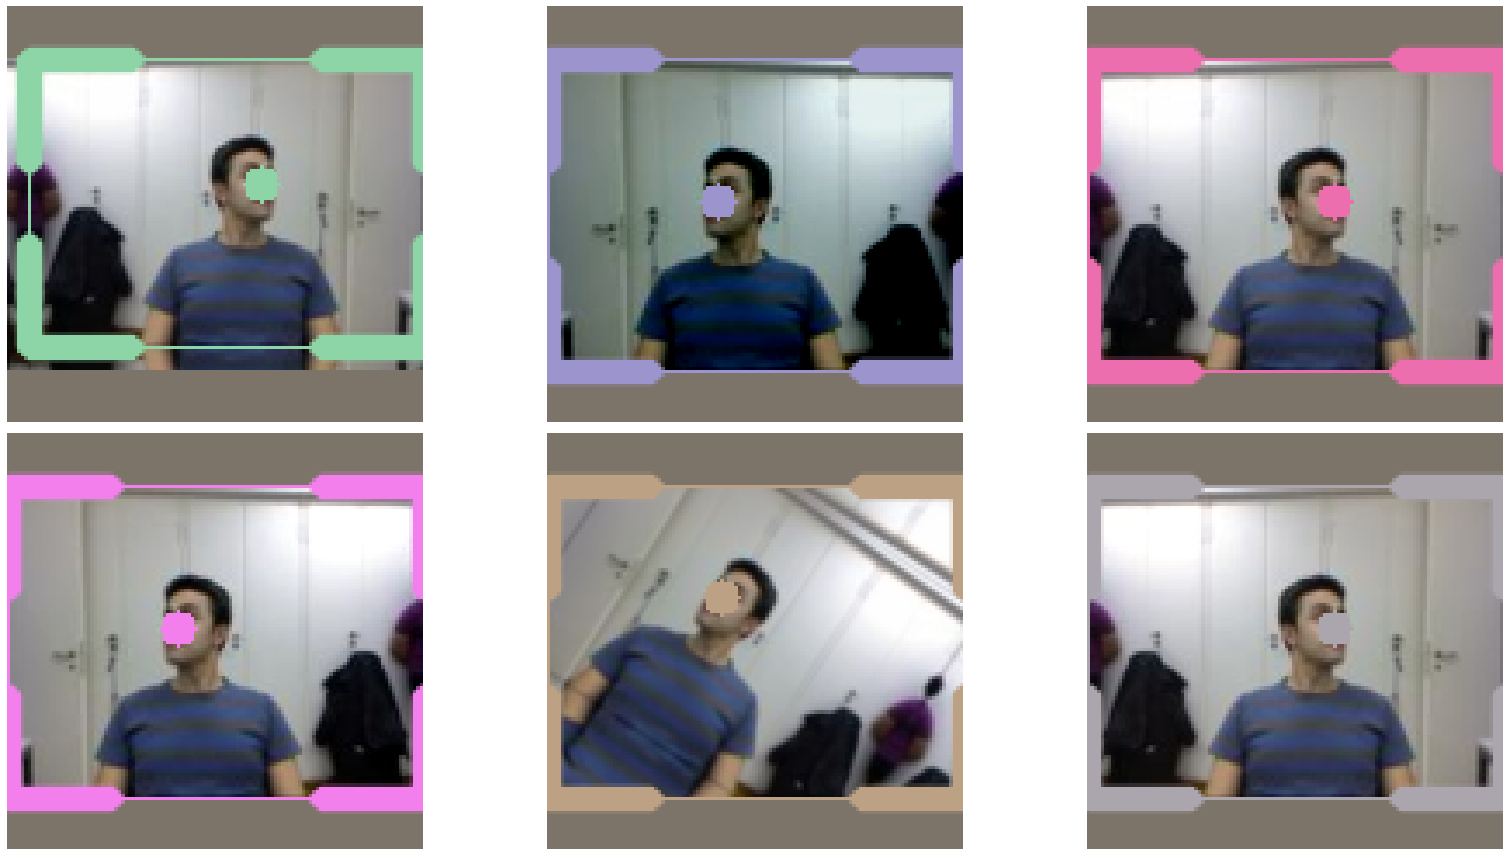

In [ ]:
presize = 240
size = 120

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize, crop_fn=None), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

samples = [train_ds[5] for _ in range(6)]
show_samples(samples, ncols=3, display_label=False)

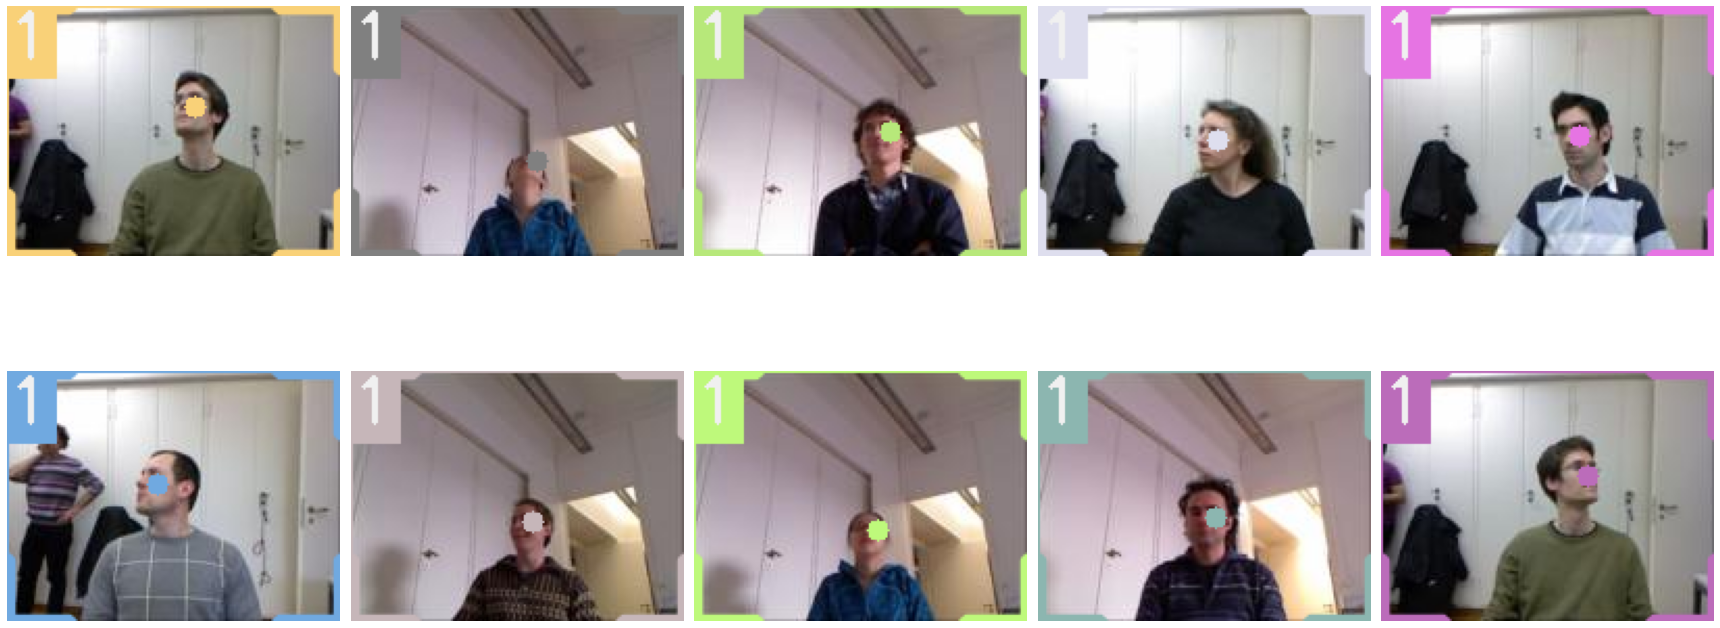

In [ ]:
# `show_records` works too, of course!
show_records(valid_records[:10], ncols=5)

## Defining dataloaders

In [ ]:
train_dl = keypoint_rcnn.train_dl(train_ds, batch_size=32, num_workers=4, shuffle=True)
valid_dl = keypoint_rcnn.valid_dl(train_ds, batch_size=32, num_workers=4, shuffle=False)

Let's look into `train_dl` by getting the first batch.

In [ ]:
(x, y), samps = first(train_dl)

As expected we get 3 sets of 32 objects (matching the batch size)

In [ ]:
len(x), len(y), len(samps)

(32, 32, 32)

Looking into the first image of the first batch...

```
# This is formatted as code
```



In [ ]:
x[0].shape

torch.Size([3, 120, 120])

... and its labels ...

In [ ]:
y[0]

{'boxes': tensor([[  0.,  15., 120., 105.]]),
 'keypoints': tensor([[[62.5242, 62.3555,  1.0000]]]),
 'labels': tensor([1])}

... and the full sample

In [ ]:
samps[0]

{'bboxes': [<BBox (xmin:0.0, ymin:15.0, xmax:120.0, ymax:105.0)>],
 'filepath': Path('/root/.icevision/data/biwi/biwi_sample/images/110.jpg'),
 'height': 90,
 'imageid': 110,
 'img': array([[[ 0.00556549, -0.00490194,  0.00819174],
         [ 0.00556549, -0.00490194,  0.00819174],
         [ 0.00556549, -0.00490194,  0.00819174],
         ...,
         [ 0.00556549, -0.00490194,  0.00819174],
         [ 0.00556549, -0.00490194,  0.00819174],
         [ 0.00556549, -0.00490194,  0.00819174]],
 
        [[ 0.00556549, -0.00490194,  0.00819174],
         [ 0.00556549, -0.00490194,  0.00819174],
         [ 0.00556549, -0.00490194,  0.00819174],
         ...,
         [ 0.00556549, -0.00490194,  0.00819174],
         [ 0.00556549, -0.00490194,  0.00819174],
         [ 0.00556549, -0.00490194,  0.00819174]],
 
        [[ 0.00556549, -0.00490194,  0.00819174],
         [ 0.00556549, -0.00490194,  0.00819174],
         [ 0.00556549, -0.00490194,  0.00819174],
         ...,
         [ 0.0055654

## Defining the model

By running `model = keypoint_rcnn.model(num_keypoints=1)` (e.g. the cell below) we invoke a `torchvision.models.detection.keypointrcnn_resnet50_fpn` model pretrained on COCO. We just need to change the number of keypoints from the original 17 (COCO includes 17 human keypoints) to 1, given in BIWI we have just the center of the person's face.

IceVision is very flexible though. You can pass any backbone among the ones listed [here](https://github.com/airctic/icevision/tree/master/icevision/backbones). Be aware that doing so, you are building a network on top of a backbone pretrained on ImageNet, *not COCO*. So you might need to train for longer.

```
backbone = backbones.resnet_fpn.resnet50(pretrained=True)
model = keypoint_rcnn.model(backbone=backbone, num_keypoints=1)
```

In [ ]:
model = keypoint_rcnn.model(num_keypoints=1)

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


## Training a `fastai.learner`

We are not adding any metrics to the learner as we are still figuring out which one makes the most sense to include. Right now, only train and validation losses are logged. 

In [ ]:
learn = keypoint_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model)

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.0002754228771664202)

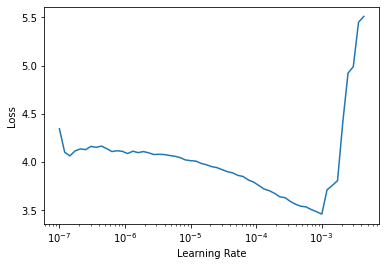

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10,1e-4, freeze_epochs=5)

epoch,train_loss,valid_loss,time
0,3.874714,3.756156,00:28
1,3.705212,3.461587,00:27
2,3.566403,3.049415,00:24
3,3.393293,2.809602,00:24
4,3.218251,2.540171,00:21


epoch,train_loss,valid_loss,time
0,2.456814,2.415040,00:29
1,2.428034,2.328304,00:23
2,2.360670,2.198649,00:35
3,2.288280,1.995884,00:36
4,2.224117,2.029325,00:37
5,2.156394,1.889692,00:37
6,2.125497,1.814186,00:24
7,2.069074,1.770032,00:24
8,2.037471,1.780256,00:22
9,1.997013,1.822499,00:31


Visualing what the model has learned. `show_results` magic in action.

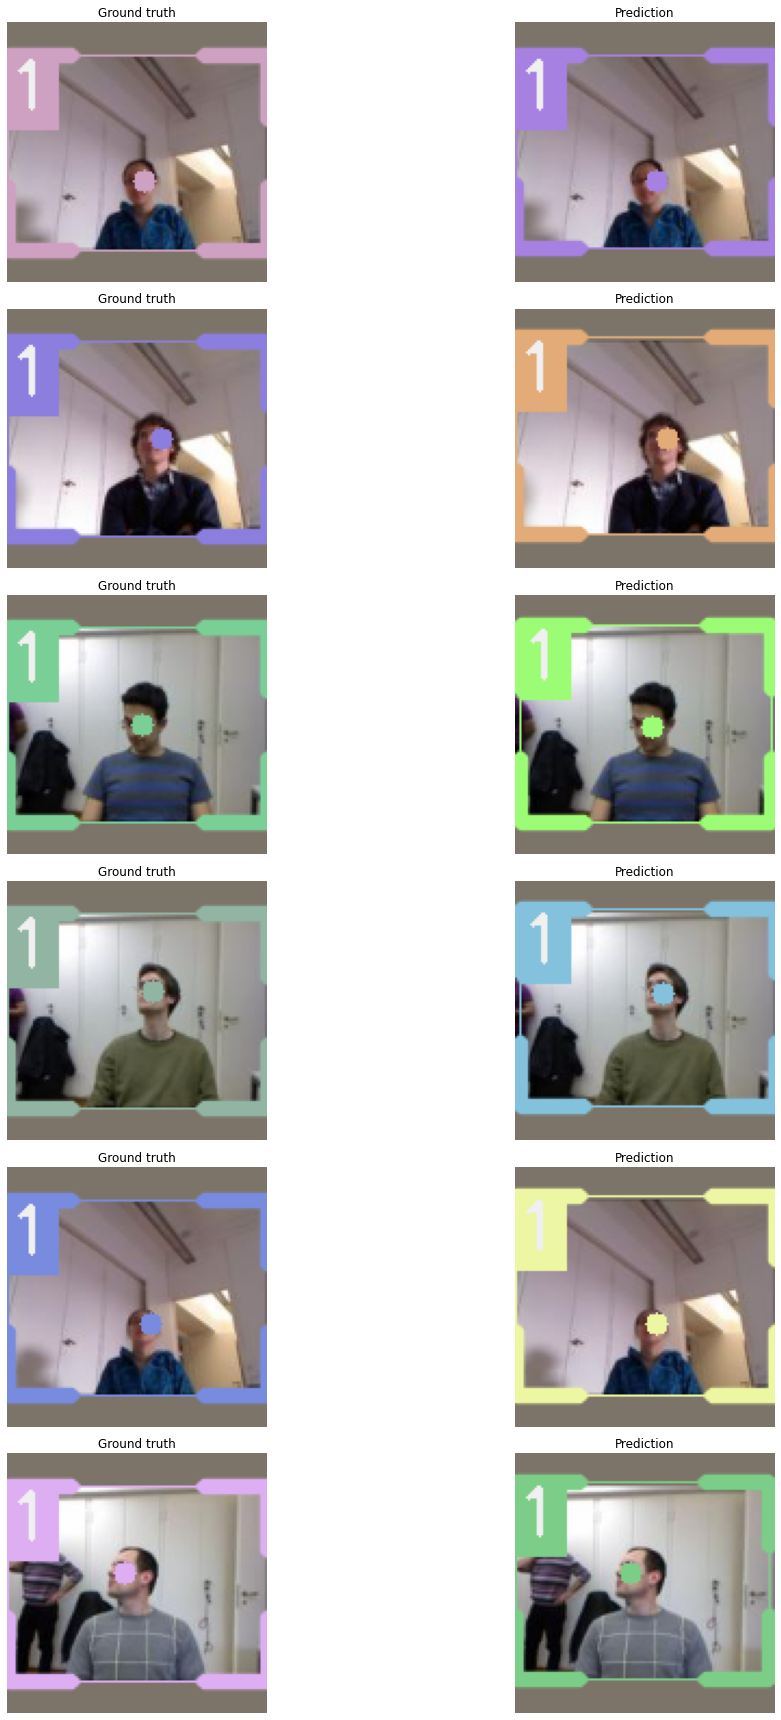

In [ ]:
keypoint_rcnn.show_results(model, valid_ds, num_samples=6)

## Running inference with the fastai trained model

In [ ]:
infer_dl = keypoint_rcnn.infer_dl(valid_ds, batch_size=8)
samples, preds = keypoint_rcnn.predict_dl(model=model, infer_dl=infer_dl)

In [ ]:
preds[1]

{'above_threshold': tensor([True], device='cuda:0'),
 'bboxes': [<BBox (xmin:0.725128173828125, ymin:13.708965301513672, xmax:120.0, ymax:106.04324340820312)>],
 'keypoints': [<KeyPoints (N visible keypoints: 1)>],
 'keypoints_scores': array([[18.758635]], dtype=float32),
 'labels': array([1]),
 'scores': array([0.99993837], dtype=float32)}

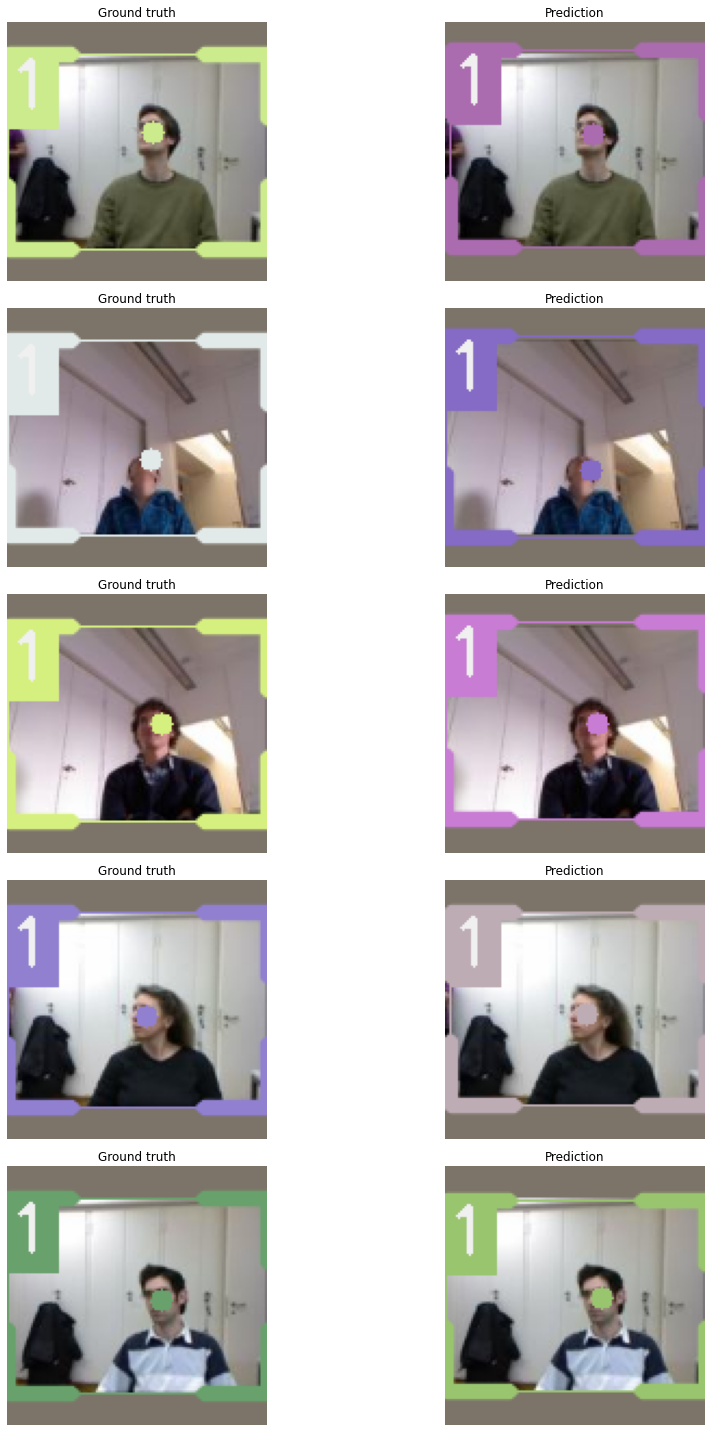

In [ ]:
show_preds(samples=samples[:5], preds=preds[:5], show=True)

## Training a PyTorch Lightning model
Using the same `torchvision.models.detection.keypointrcnn_resnet50_fpn` architecture defined above.

In [ ]:
class LightModel(keypoint_rcnn.lightning.ModelAdapter):
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)

model = keypoint_rcnn.model(num_keypoints=1)
light_model = LightModel(model)

trainer = pl.Trainer(max_epochs=20, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | KeypointRCNN | 59.0 M
INFO:lightning:
  | Name  | Type         | Params
---------------------------------------
0 | model | KeypointRCNN | 59.0 M


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

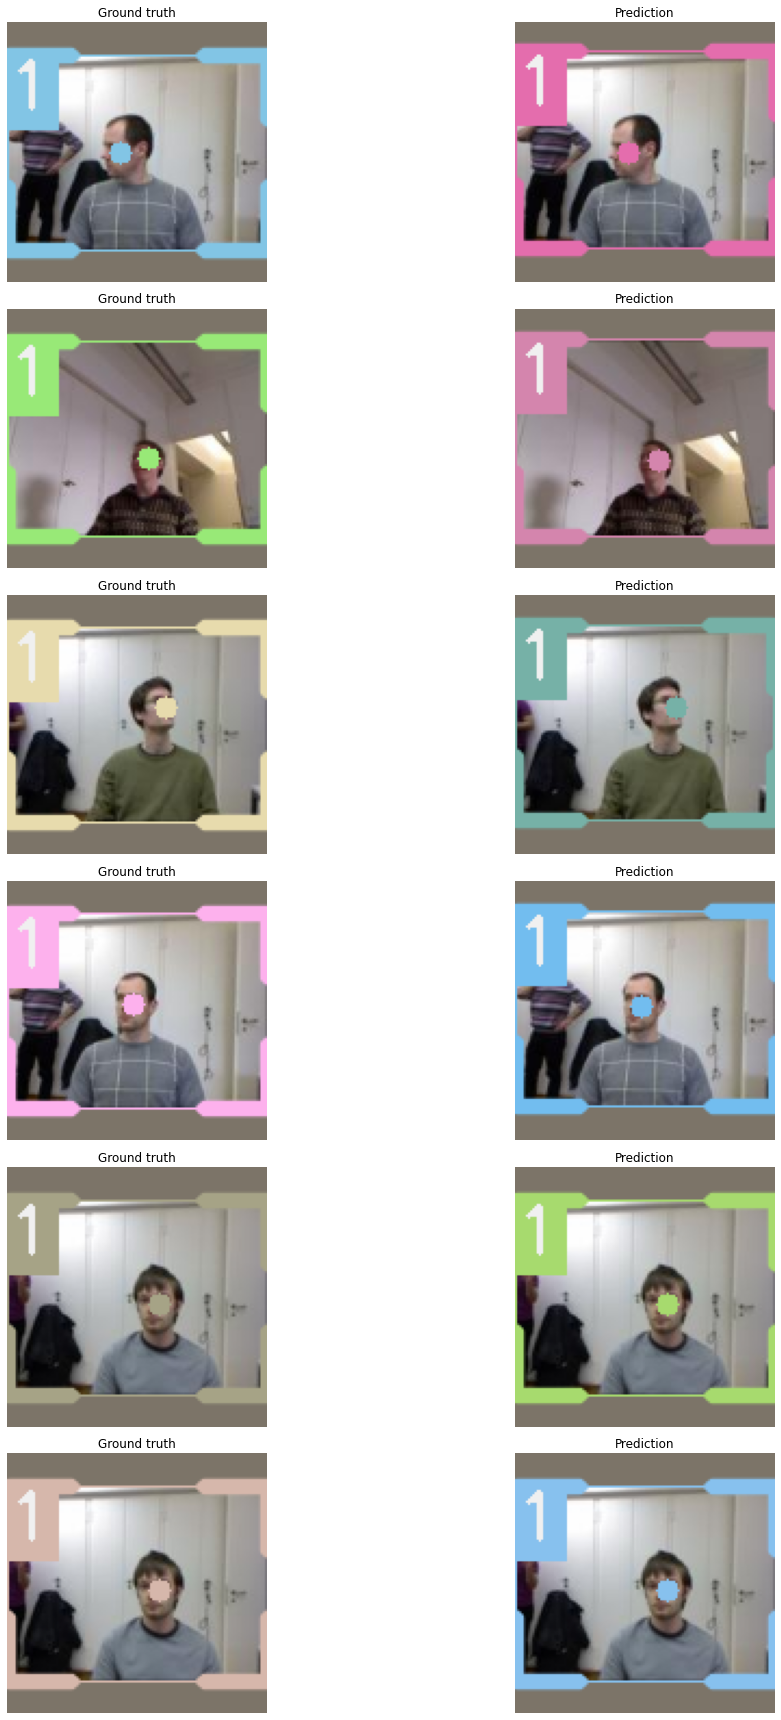

In [ ]:
keypoint_rcnn.show_results(light_model, valid_ds)

That's it! Happy learning!